In [18]:
import sys
import os
directory = os.path.abspath(os.path.join('..'))
sys.path.append(directory)
import numpy as np
from matplotlib import pyplot as plt
from scripts.model_params import *
from scripts.cell_model_batch_culture import *
from scripts.batch_culture_simulation import *
import os
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination

Defining and importing base parameters

In [19]:
# defining parameters
sS0 = 0.5; cultvol = 1.25 #quality of the nutrients and volume of the culture
vX = 726; kX = 1e3 # X export parameters
tmax = 10000; runintmax = 1e6 #simulation time parameters

N0  = 1e6
xS0 = 4.180555555555556e+22; # amount of glucose in media = 10g/L in 1.25L working vol in 3L vessel
xS0 = 4.180555555555556e+21
M0 = 1e8 

Defining the system topology parameters

In [20]:
#choosing the product transport method. 1 indicates this method is included
lin_trans      = 1
Tp_trans       = 0
T_trans        = 0
diff_trans     = 0

#mutaually exclusive; only one of these can be 1, rest must be 0
eprodtox       = 1
elongationtox  = 0

topology = [lin_trans, Tp_trans, T_trans, diff_trans, eprodtox, elongationtox]

creating the host and engineered parameter arrays

In [21]:
base_params = [xS0, runintmax, tmax, N0, topology]

hPR0, xPR0 = model_params(sS0, vX, kX, cultvol, leaky_control=False)
hPR = np.array(hPR0)
xPR = np.array(xPR0)
# 0     1       2       3       4         5        6        7           8
#[w0,   wE,     wEp,    wTF,    wpTox,    wTp,     k_Ep,    Km_Ep,      k_Tp,
#   9      10             11                 12
# # Km_Tp, a_energy_pTox, a_elongation_pTox, K_E, 
#   13      14      15       16       17   18
# # K_pTox, kdiffP, VolCell, VolCult, ksf, ksr]

Setting specific circuit parameters

In [22]:
wE = 20; wEp = 20; wTF = 20; wpTox = 2;
K_E = 0.3; K_pTox = 1.0

xPR[[1, 2, 3, 4, 12, 13]] = [wE, wEp, wTF, wpTox, K_E, K_pTox]

param_indices = [1, 2]     # optimise xPR[2], xPR[5], xPR[7]
lb = [0,   0]          # lower bounds for each parameter
ub = [100, 100]          # upper bounds

A function to create a local xPR for each candidate parameters

In [23]:
import copy

def map_params_to_xPR(xPR_template, x, param_indices):
    xPR_local = copy.deepcopy(xPR_template)
    for xi, idx in zip(x, param_indices):
        xPR_local[idx] = float(xi)
    return xPR_local

Log objective helper

In [38]:
EPS = 1e-30

def log_obj(vP, pY):
    vP_log = np.log10(vP + EPS)
    pY_log = np.log10(pY + EPS)
    return -vP_log, -pY_log  

Writing a wrapper to take wEp and return the productivity and yield

In [24]:
xPR_temp = xPR.copy()
def obj_vector(X):
    xPR_temp = xPR.copy()
    xPR_temp[1] = X[0]
    xPR_temp[2] = X[1]
    vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_temp)
    return -vP, -pY     

Setting up the optimisation problems

In [39]:
x_lower, x_upper = 0, 100


class MaxVProdProblem(ElementwiseProblem):

    def __init__(self, xPR_template, param_indices, lb, ub):
        super().__init__(n_var=len(param_indices),
                         n_obj=1, xl=lb, xu=ub)
        self.xPR_template = xPR_template
        self.param_indices = param_indices

    def _evaluate(self, x, out, *args, **kwargs):

        xPR_local = map_params_to_xPR(self.xPR_template, x, self.param_indices)
        vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_local)

        vP_log, _ = log_obj(vP, pY)
        out["F"] = [vP_log]


class MaxYieldProblem(ElementwiseProblem):

    def __init__(self, xPR_template, param_indices, lb, ub):
        super().__init__(n_var=len(param_indices),
                         n_obj=1, xl=lb, xu=ub)
        self.xPR_template = xPR_template
        self.param_indices = param_indices

    def _evaluate(self, x, out, *args, **kwargs):

        xPR_local = map_params_to_xPR(self.xPR_template, x, self.param_indices)
        vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_local)

        _, pY_log = log_obj(vP, pY)
        out["F"] = [pY_log]

Running the optimisation to find optimal vP

In [ ]:
res1 = minimize(
    MaxVProdProblem(xPR, param_indices, lb, ub),
    GA(pop_size=30),
    seed=1
)
max_vP_log = abs(res1.F[0])
print("Max log vP:", max_vP_log)

Running the optimisation to find optimisal pY

In [ ]:
res2 = minimize(
    MaxYieldProblem(xPR, param_indices, lb, ub),
    GA(pop_size=30),
    seed=1
)
max_pY_log = abs(res2.F[0])
print("Max log pY:", max_pY_log)

Max pY: 2.1499417408531802e-11


Setting up the multiobjective optimisation problem

In [ ]:
scale = np.array([max_vP_log, max_pY_log])
class MultiObjScaled(ElementwiseProblem):

    def __init__(self, xPR_template, param_indices, lb, ub, scale):
        super().__init__(n_var=len(param_indices),
                         n_obj=2, xl=lb, xu=ub)
        self.xPR_template = xPR_template
        self.param_indices = param_indices
        self.scale = scale

    def _evaluate(self, x, out, *args, **kwargs):

        xPR_local = map_params_to_xPR(self.xPR_template, x, self.param_indices)
        vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_local)

        # log-transformed objectives
        vP_log, pY_log = log_obj(vP, pY)

        # scaled
        obj = np.array([vP_log, pY_log]) / self.scale
        out["F"] = obj



Running the optimisation

In [ ]:
res = minimize(
    MultiObjScaled(xPR, param_indices, lb, ub, scale),
    NSGA2(pop_size=60),
    get_termination("n_gen", 80),
    seed=1,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       60 |      1 |             - |             -
     2 |      120 |      2 |  1.0000000000 |         ideal
     3 |      180 |      1 |  0.1400398303 |         ideal
     4 |      240 |      1 |  0.0211383758 |         ideal
     5 |      300 |      1 |  0.000000E+00 |             f
     6 |      360 |      1 |  0.0236620433 |         ideal
     7 |      420 |      1 |  0.0283685802 |         ideal
     8 |      480 |      1 |  0.1113449606 |         ideal
     9 |      540 |      2 |  1.0000000000 |         ideal
    10 |      600 |      1 |  0.0452910254 |         ideal
    11 |      660 |      2 |  2.8766198607 |         ideal
    12 |      720 |      1 |  0.0358755453 |         ideal
    13 |      780 |      1 |  0.0660520330 |         ideal
    14 |      840 |      1 |  0.0212741969 |         ideal
    15 |      900 |      1 |  0.0300878596 |         ideal
    16 |      960 |      1 |  0.0032247979 |         ide

Extracting the pareto front

In [ ]:
pareto_X = res.X
pareto_scaled = res.F
pareto_log = pareto_scaled * scale   # undo scale

vP_log_vals = pareto_log[:, 0]
pY_log_vals = pareto_log[:, 1]

vP_vals = 10 ** (-vP_log_vals)
pY_vals = 10 ** (-pY_log_vals)

print("Pareto points:", len(vP_vals))

Now plotting the pareto front

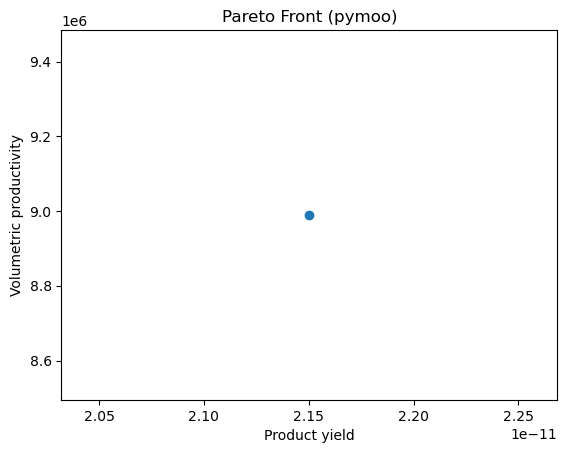

In [33]:
plt.scatter(pY_vals, vP_vals)
plt.xlabel("Product yield")
plt.ylabel("Volumetric productivity")
plt.title("Pareto Front (pymoo)")
plt.show()

In [35]:
def test_grid():
    print("Testing variability of vP and pY across parameter space")
    
    grid = np.random.uniform(lb, ub, size=(20, len(param_indices)))

    results = []
    for x in grid:
        xPR_local = map_params_to_xPR(xPR, x, param_indices)
        vP, pY = batch_cult_prod_yield_calc(base_params, hPR, xPR_local)
        results.append((vP, pY))

    print(np.array(results))
    print("Number of unique rows:", len(np.unique(results, axis=0)))

test_grid()

Testing variability of vP and pY across parameter space
[[1.44510722e+06 9.64397880e-13]
 [1.36403072e+06 9.47731614e-13]
 [1.07464878e+06 7.67663644e-13]
 [9.11056205e+05 5.32319881e-13]
 [1.25449522e+06 8.66104058e-13]
 [1.42102913e+06 5.06404334e-13]
 [1.81107084e+06 1.10760425e-12]
 [2.27341189e+06 2.15892377e-12]
 [6.32326354e+05 2.26777461e-13]
 [1.24594326e+06 6.36467530e-13]
 [3.87340187e+06 9.26528022e-12]
 [1.15714745e+06 6.92290369e-13]
 [1.29653500e+06 8.33235610e-13]
 [1.55191902e+06 8.22891507e-13]
 [4.61467296e+06 2.05984624e-12]
 [2.14064233e+06 2.11823236e-12]
 [8.63698750e+05 3.74203682e-13]
 [1.06645771e+06 7.78752553e-13]
 [1.05336633e+04 2.49027720e-15]
 [1.99041606e+06 8.42431436e-13]]
Number of unique rows: 20
